<a href="https://colab.research.google.com/github/Manjushree329/Student-feedback-analysis-/blob/main/Student_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STUDENT FEEDBACK ANALYSIS - ML CLASSIFICATION

1. LOADING AND EXPLORING THE DATASET
----------------------------------------
Dataset shape: (185, 12)
Number of records: 185
Number of features: 12

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   teaching             185 non-null    int64  
 1   teaching.1           185 non-null    object 
 2   coursecontent        184 non-null    float64
 3   coursecontent.1      185 non-null    object 
 4   examination          184 non-null    float64
 5   Examination          185 non-null    object 
 6   labwork              185 non-null    int64  
 7   labwork.1            185 non-null    object 
 8   library_facilities   182 non-null    float64
 9    library_facilities  185 non-null    object 
 10  extracurricular      185 non-null    int64  
 11  extracurricular.1    185 non-

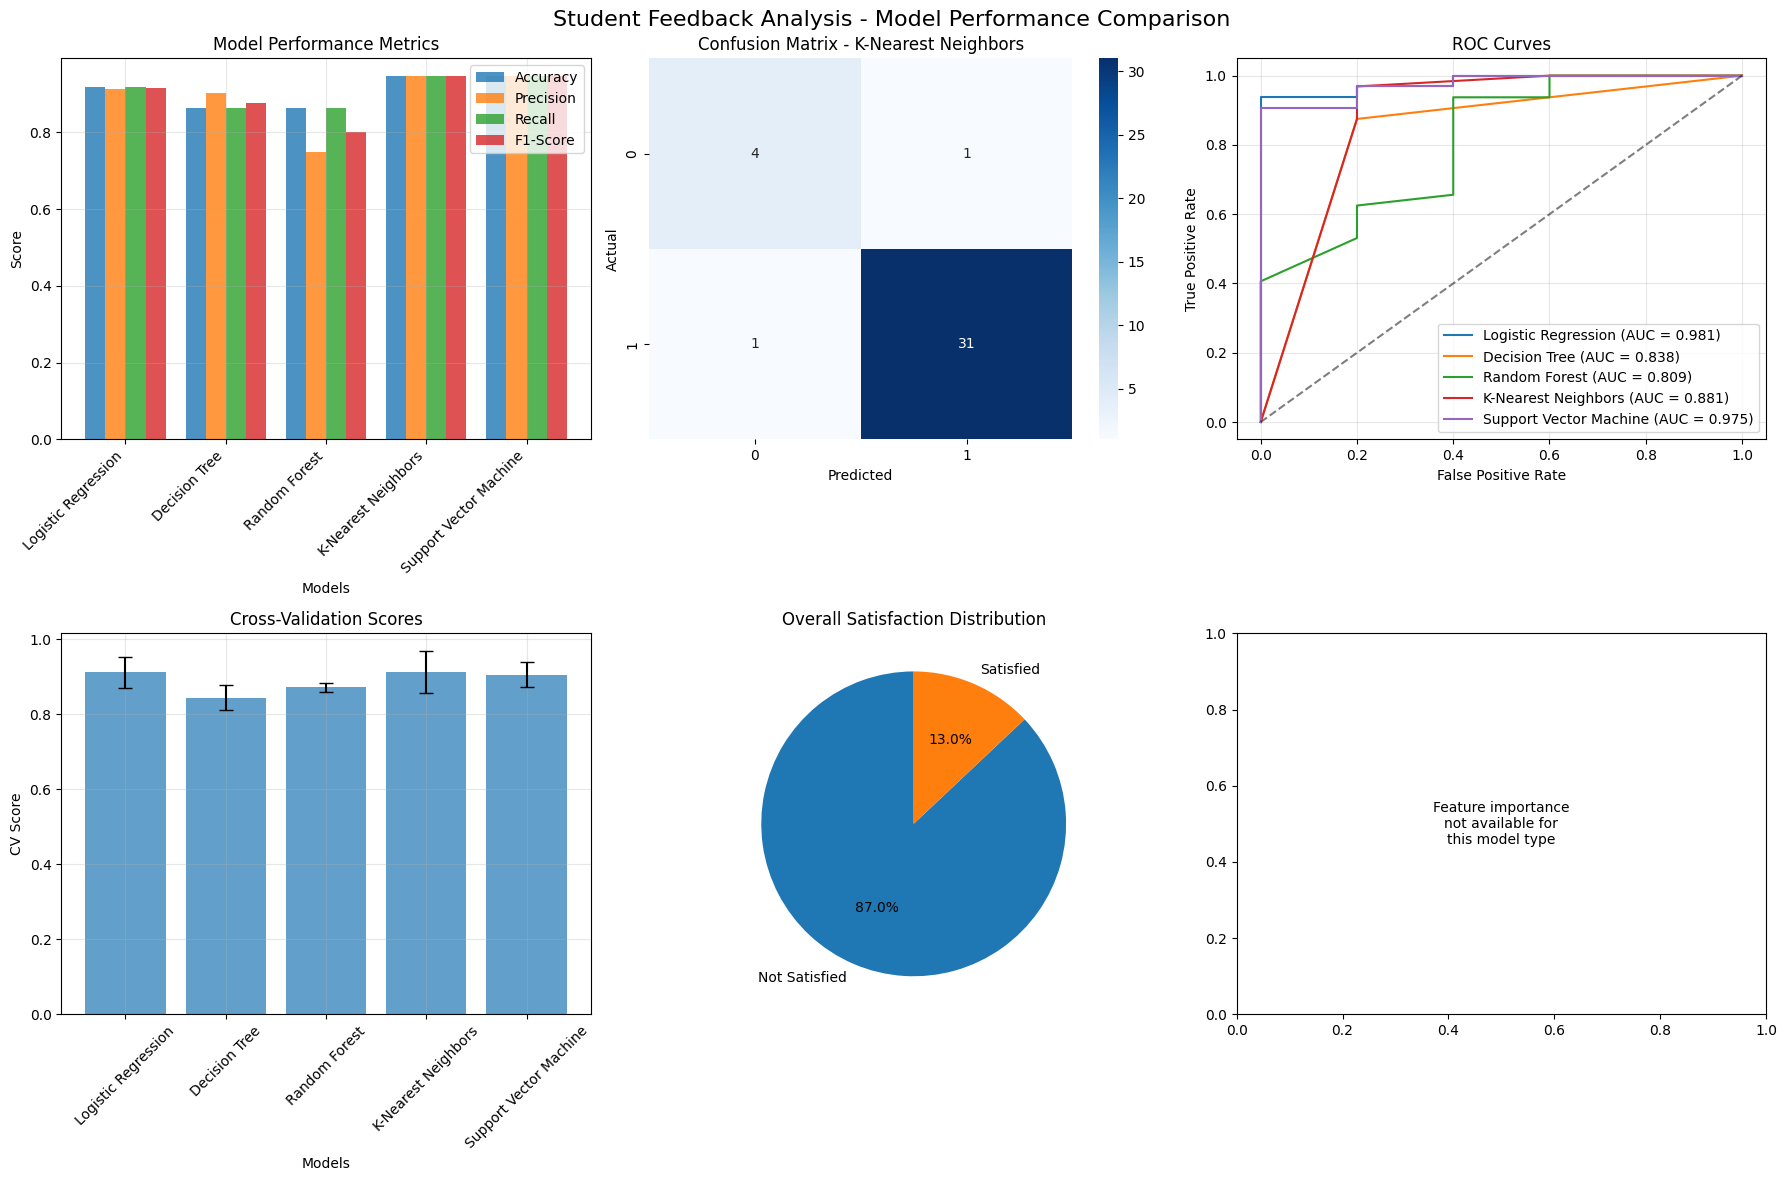



7. DETAILED ANALYSIS AND INSIGHTS
--------------------------------------------------

Classification Report for Best Model (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.97      0.97      0.97        32

    accuracy                           0.95        37
   macro avg       0.88      0.88      0.88        37
weighted avg       0.95      0.95      0.95        37


Satisfaction Analysis by Category:
-----------------------------------
teaching: 74.05% satisfied
coursecontent: 69.19% satisfied
examination: 70.27% satisfied
labwork: 71.35% satisfied
library_facilities: 68.65% satisfied
extracurricular: 83.24% satisfied

Areas needing most improvement:
1. library_facilities: 68.65% satisfaction
2. coursecontent: 69.19% satisfaction
3. examination: 70.27% satisfaction

Top performing areas:
1. labwork: 71.35% satisfaction
2. teaching: 74.05% satisfaction
3. extracurricular: 83.24% sa

In [ ]:
# Student Feedback Analysis using Machine Learning
# Analyzing satisfaction levels and identifying improvement areas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("="*60)
print("STUDENT FEEDBACK ANALYSIS - ML CLASSIFICATION")
print("="*60)

# Load the dataset
print("\n1. LOADING AND EXPLORING THE DATASET")
print("-" * 40)

# Read the CSV file
df = pd.read_csv('finalDataset0.2.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of records: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())

print("\nFirst few rows:")
print(df.head())

print("\nColumn names:")
print(df.columns.tolist())

# Check for missing values
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Analyze the target variables (satisfaction scores)
satisfaction_columns = ['teaching', 'coursecontent', 'examination',
                       'labwork', 'library_facilities', 'extracurricular']

print(f"\nSatisfaction score distributions:")
for col in satisfaction_columns:
    if col in df.columns:
        print(f"{col}: {df[col].value_counts().sort_index()}")

# 2. DATA PREPROCESSING
print("\n\n2. DATA PREPROCESSING")
print("-" * 40)

# Create overall satisfaction score (target variable)
# Convert satisfaction scores to binary classification (satisfied vs not satisfied)
# 1 = Satisfied, 0 = Not Satisfied (-1 and 0 become 0, 1 stays 1)

def convert_to_binary_satisfaction(score):
    return 1 if score == 1 else 0

# Apply conversion to satisfaction columns
for col in satisfaction_columns:
    if col in df.columns:
        df[f'{col}_binary'] = df[col].apply(convert_to_binary_satisfaction)

# Create overall satisfaction score (average of all satisfaction areas)
binary_cols = [f'{col}_binary' for col in satisfaction_columns if f'{col}_binary' in df.columns]
df['overall_satisfaction'] = df[binary_cols].mean(axis=1)

# Convert to binary: satisfied if overall satisfaction >= 0.5
df['satisfaction_label'] = (df['overall_satisfaction'] >= 0.5).astype(int)

print(f"Overall satisfaction distribution:")
print(df['satisfaction_label'].value_counts())

# Text preprocessing for feedback comments
text_columns = []
for col in df.columns:
    if df[col].dtype == 'object' and col not in satisfaction_columns:
        text_columns.append(col)

print(f"\nText columns identified: {text_columns}")

# Combine all text feedback into one column
if text_columns:
    df['combined_feedback'] = df[text_columns].fillna('').agg(' '.join, axis=1)
else:
    # If no text columns found, create from the feedback structure
    feedback_cols = [col for col in df.columns if col not in satisfaction_columns +
                    [f'{col}_binary' for col in satisfaction_columns] +
                    ['overall_satisfaction', 'satisfaction_label']]
    if feedback_cols:
        df['combined_feedback'] = df[feedback_cols].fillna('').astype(str).agg(' '.join, axis=1)
    else:
        df['combined_feedback'] = 'No feedback available'

# Feature Engineering
print("\n3. FEATURE ENGINEERING")
print("-" * 40)

# Text features using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

# Fit and transform the combined feedback
X_text = vectorizer.fit_transform(df['combined_feedback'])
text_feature_names = vectorizer.get_feature_names_out()

# Numerical features (satisfaction scores)
numerical_features = []
for col in satisfaction_columns:
    if col in df.columns:
        numerical_features.append(col)

X_numerical = df[numerical_features].fillna(0)

# Combine text and numerical features
from scipy.sparse import hstack
X_combined = hstack([X_text, X_numerical.values])

# Target variable
y = df['satisfaction_label']

print(f"Feature matrix shape: {X_combined.shape}")
print(f"Text features: {X_text.shape[1]}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# 4. TRAIN-TEST SPLIT
print("\n4. TRAIN-TEST SPLIT")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training target distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test target distribution: {pd.Series(y_test).value_counts().to_dict()}")

# 5. MODEL IMPLEMENTATION AND COMPARISON
print("\n\n5. MODEL IMPLEMENTATION AND COMPARISON")
print("-" * 50)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}

# Dictionary to store results
results = {}

print("Training and evaluating models...")
print("-" * 30)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  CV Score: {cv_mean:.4f} (+/- {cv_std*2:.4f})")

# 6. RESULTS COMPARISON AND VISUALIZATION
print("\n\n6. RESULTS COMPARISON AND ANALYSIS")
print("-" * 50)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()],
    'ROC-AUC': [results[model]['roc_auc'] if results[model]['roc_auc'] else 0 for model in results.keys()],
    'CV Mean': [results[model]['cv_mean'] for model in results.keys()],
    'CV Std': [results[model]['cv_std'] for model in results.keys()]
})

print("Model Performance Comparison:")
print(comparison_df.round(4))

# Find best performing model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"\nBest performing model: {best_model_name}")
print(f"Best F1-Score: {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'F1-Score']:.4f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Student Feedback Analysis - Model Performance Comparison', fontsize=16)

# 1. Model Performance Comparison
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics):
    ax1.bar(x + i*width, comparison_df[metric], width, label=metric, alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Metrics')
ax1.set_xticks(x + width*1.5)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Confusion Matrix for Best Model
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix - {best_model_name}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 3. ROC Curve
ax3 = axes[0, 2]
for name in results.keys():
    if results[name]['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
        auc_score = results[name]['roc_auc']
        ax3.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Cross-Validation Scores
ax4 = axes[1, 0]
cv_means = comparison_df['CV Mean']
cv_stds = comparison_df['CV Std']
ax4.bar(comparison_df['Model'], cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
ax4.set_xlabel('Models')
ax4.set_ylabel('CV Score')
ax4.set_title('Cross-Validation Scores')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# 5. Satisfaction Distribution
ax5 = axes[1, 1]
satisfaction_dist = df['satisfaction_label'].value_counts()
ax5.pie(satisfaction_dist.values, labels=['Not Satisfied', 'Satisfied'],
        autopct='%1.1f%%', startangle=90)
ax5.set_title('Overall Satisfaction Distribution')

# 6. Feature Importance (for tree-based models)
ax6 = axes[1, 2]
if best_model_name in ['Decision Tree', 'Random Forest']:
    if best_model_name == 'Random Forest':
        importances = best_model.feature_importances_
    else:
        importances = best_model.feature_importances_

    # Get top 10 features
    if len(numerical_features) > 0:
        feature_names = list(text_feature_names) + numerical_features
        top_indices = np.argsort(importances)[-10:]
        top_importances = importances[top_indices]
        top_features = [feature_names[i] if i < len(feature_names) else f'Feature_{i}'
                       for i in top_indices]

        ax6.barh(range(len(top_features)), top_importances)
        ax6.set_yticks(range(len(top_features)))
        ax6.set_yticklabels(top_features)
        ax6.set_xlabel('Importance')
        ax6.set_title(f'Top 10 Feature Importances - {best_model_name}')
    else:
        ax6.text(0.5, 0.5, 'Feature importance\nnot available',
                ha='center', va='center', transform=ax6.transAxes)
else:
    ax6.text(0.5, 0.5, 'Feature importance\nnot available for\nthis model type',
            ha='center', va='center', transform=ax6.transAxes)

plt.tight_layout()
plt.show()

# 7. DETAILED ANALYSIS AND INSIGHTS
print("\n\n7. DETAILED ANALYSIS AND INSIGHTS")
print("-" * 50)

print(f"\nClassification Report for Best Model ({best_model_name}):")
print(classification_report(y_test, results[best_model_name]['y_pred']))

# Analyze satisfaction by category
print("\nSatisfaction Analysis by Category:")
print("-" * 35)
category_satisfaction = {}
for col in satisfaction_columns:
    if f'{col}_binary' in df.columns:
        satisfaction_rate = df[f'{col}_binary'].mean()
        category_satisfaction[col] = satisfaction_rate
        print(f"{col}: {satisfaction_rate:.2%} satisfied")

# Sort categories by satisfaction rate
sorted_categories = sorted(category_satisfaction.items(), key=lambda x: x[1])
print(f"\nAreas needing most improvement:")
for i, (category, rate) in enumerate(sorted_categories[:3]):
    print(f"{i+1}. {category}: {rate:.2%} satisfaction")

print(f"\nTop performing areas:")
for i, (category, rate) in enumerate(sorted_categories[-3:]):
    print(f"{i+1}. {category}: {rate:.2%} satisfaction")

# Model justification
print("\n\n8. MODEL JUSTIFICATION AND RECOMMENDATIONS")
print("-" * 55)

model_justifications = {
    'Logistic Regression': 'Fast, interpretable, works well with text features (TF-IDF)',
    'Decision Tree': 'Highly interpretable, can capture non-linear relationships',
    'Random Forest': 'Robust, handles mixed data types, provides feature importance',
    'K-Nearest Neighbors': 'Simple, non-parametric, good for local patterns',
    'Support Vector Machine': 'Effective for high-dimensional data, good with text'
}

print("Model Selection Justification:")
for model_name, justification in model_justifications.items():
    print(f"\n{model_name}:")
    print(f"  - {justification}")
    if model_name in results:
        print(f"  - Performance: F1-Score = {results[model_name]['f1_score']:.4f}")

print(f"\nRECOMMENDED MODEL: {best_model_name}")
print(f"Reason: Achieved the highest F1-Score ({results[best_model_name]['f1_score']:.4f})")
print("This model provides the best balance between precision and recall for")
print("identifying student satisfaction levels.")

print("\n\n9. BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("-" * 50)

print("Key Findings:")
print("1. Model Performance:")
print(f"   - Best model achieved {results[best_model_name]['accuracy']:.1%} accuracy")
print(f"   - F1-Score of {results[best_model_name]['f1_score']:.3f} indicates good balance")

print("\n2. Satisfaction Analysis:")
overall_satisfaction_rate = df['satisfaction_label'].mean()
print(f"   - Overall satisfaction rate: {overall_satisfaction_rate:.1%}")

if category_satisfaction:
    lowest_satisfaction = min(category_satisfaction.values())
    highest_satisfaction = max(category_satisfaction.values())
    print(f"   - Satisfaction ranges from {lowest_satisfaction:.1%} to {highest_satisfaction:.1%}")

print("\n3. Recommendations for Improvement:")
if sorted_categories:
    for i, (category, rate) in enumerate(sorted_categories[:3]):
        print(f"   - Focus on improving {category.replace('_', ' ').title()}")
        print(f"     Current satisfaction: {rate:.1%}")

print("\n4. Implementation Strategy:")
print("   - Use this model to automatically classify feedback sentiment")
print("   - Prioritize resources on lowest-performing areas")
print("   - Monitor satisfaction trends over time")
print("   - Implement targeted interventions based on feedback analysis")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)